# Project 9: Content Recommendation System
## My Content - Article Recommendation MVP

This notebook implements:
1. Data Exploration and Analysis
2. Collaborative Filtering (User-based, Item-based, SVD)
3. Content-Based Filtering (using embeddings)
4. Hybrid Recommendation System
5. Model Evaluation and Comparison
6. Model Export for Deployment

In [1]:
# Import libraries
import sys
import os

# Add project root to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 2.1.3
Pandas version: 2.2.3


## 1. Data Loading and Exploration

In [2]:
# Import custom modules
from src.config import DATA_DIR, MODEL_DIR, N_RECOMMENDATIONS
from src.data_loader import DataLoader
from src.collaborative_filtering import CollaborativeFiltering
from src.content_based import ContentBasedRecommender
from src.hybrid_recommender import HybridRecommender
from src.utils import (
    evaluate_model, plot_interaction_distribution, plot_model_comparison,
    precision_at_k, recall_at_k, ndcg_at_k, create_user_item_dict
)

print(f"Data directory: {DATA_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data directory: /Users/durga/OpenClassrooms/Project9/data/news-portal-user-interactions-by-globocom
Model directory: /Users/durga/OpenClassrooms/Project9/P9_02_azure_function/model


In [3]:
# List available data files
if os.path.exists(DATA_DIR):
    print("Files in data directory:")
    for f in os.listdir(DATA_DIR):
        fpath = os.path.join(DATA_DIR, f)
        size = os.path.getsize(fpath) / (1024*1024)
        print(f"  - {f}: {size:.2f} MB")
else:
    print(f"Data directory not found: {DATA_DIR}")
    print("Please download the data and place it in the data/ folder")

Files in data directory:
  - clicks_sample.csv: 0.13 MB
  - clicks.zip: 36.46 MB
  - articles_embeddings.pickle: 347.18 MB
  - articles_metadata.csv: 10.58 MB
  - clicks_full.csv: 210.31 MB


In [4]:
# Initialize data loader
data_loader = DataLoader(DATA_DIR)

# Load data (update paths based on your data files)
# The dataset should contain:
# - clicks/interactions data (user_id, article_id, timestamp, etc.)
# - article metadata (optional)
# - article embeddings (optional)

# Example loading (adjust file names to match your data)
data_loader.load_data(
    clicks_path=os.path.join(DATA_DIR, 'clicks_sample.csv'),
    articles_path=os.path.join(DATA_DIR, 'articles_metadata.csv'),
    embeddings_path=os.path.join(DATA_DIR, 'articles_embeddings.pickle')
)

Loaded clicks data: 1883 interactions
Loaded articles data: 364047 articles
Loaded embeddings: 364047 articles (shape: (364047, 250))


In [5]:
# Explore clicks data
if data_loader.clicks_df is not None:
    print("Clicks Data Shape:", data_loader.clicks_df.shape)
    print("\nColumns:")
    print(data_loader.clicks_df.dtypes)
    print("\nFirst 5 rows:")
    display(data_loader.clicks_df.head())
    print("\nBasic Statistics:")
    display(data_loader.clicks_df.describe())
else:
    print("No clicks data loaded")

Clicks Data Shape: (1883, 12)

Columns:
user_id                int64
session_id             int64
session_start          int64
session_size           int64
click_article_id       int64
click_timestamp        int64
click_environment      int64
click_deviceGroup      int64
click_os               int64
click_country          int64
click_region           int64
click_referrer_type    int64
dtype: object

First 5 rows:


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2



Basic Statistics:


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1.883000e+03,1883.000000,1883.000000,1.883000e+03,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,1.506828e+12,3.459904,176717.848646,1.506830e+12,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
std,206.162865,8.679628e+08,8.679468e+05,3.037467,82324.177259,1.064938e+07,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679
min,0.000000,1.506825e+15,1.506825e+12,2.000000,2137.000000,1.506827e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,1.506827e+12,2.000000,108854.000000,1.506828e+12,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,1.506828e+12,3.000000,157541.000000,1.506828e+12,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,1.506828e+12,4.000000,236697.500000,1.506829e+12,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,1.506829e+12,24.000000,363291.000000,1.506998e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


In [6]:
# Explore articles metadata
if data_loader.articles_df is not None:
    print("Articles Data Shape:", data_loader.articles_df.shape)
    print("\nColumns:")
    print(data_loader.articles_df.dtypes)
    print("\nFirst 5 rows:")
    display(data_loader.articles_df.head())
else:
    print("No articles metadata loaded")

Articles Data Shape: (364047, 5)

Columns:
article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

First 5 rows:


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [7]:
# Explore embeddings
if data_loader.embeddings is not None:
    print(f"Number of article embeddings: {len(data_loader.embeddings)}")
    # Get sample embedding
    sample_id = list(data_loader.embeddings.keys())[0]
    sample_emb = data_loader.embeddings[sample_id]
    print(f"Embedding dimension: {len(sample_emb)}")
    print(f"Sample embedding shape: {np.array(sample_emb).shape}")
else:
    print("No embeddings loaded")

Number of article embeddings: 364047
Embedding dimension: 250
Sample embedding shape: (250,)


## 2. Data Preprocessing

In [8]:
# Preprocess data - filter users and items with too few interactions
data_loader.preprocess(
    min_user_interactions=5,
    min_article_interactions=3
)

Preprocessed data: 1883 -> 197 interactions
Unique users: 47
Unique articles: 33


In [9]:
# Get dataset statistics
stats = data_loader.get_statistics()
print("Dataset Statistics:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Dataset Statistics:
  n_interactions: 197
  n_users: 47
  n_articles: 33
  avg_interactions_per_user: 4.1915
  median_interactions_per_user: 4.0000
  avg_interactions_per_article: 5.9697
  median_interactions_per_article: 4.0000


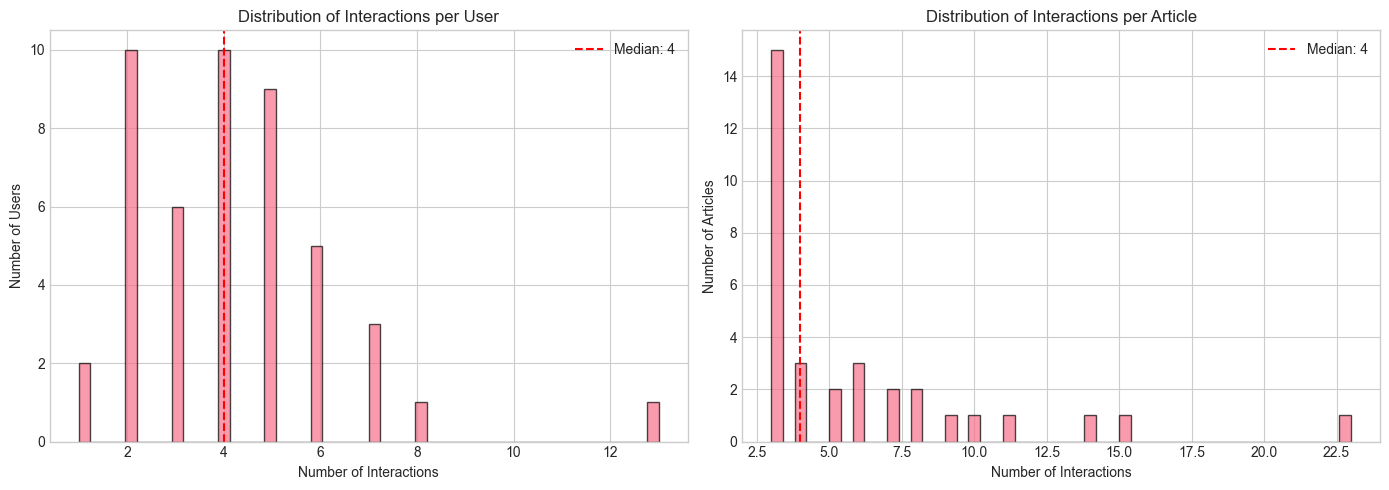

In [10]:
# Plot interaction distributions
if data_loader.clicks_df is not None:
    user_col = data_loader._get_user_column()
    article_col = data_loader._get_article_column()
    plot_interaction_distribution(data_loader.clicks_df, user_col, article_col)

In [11]:
# Train-test split (MUST be done before building user-item matrix)
train_df, test_df = data_loader.train_test_split(test_size=0.2)
print(f"Train set: {len(train_df)} interactions")
print(f"Test set: {len(test_df)} interactions")

Train set: 149 interactions
Test set: 48 interactions
Train set: 149 interactions
Test set: 48 interactions


In [12]:
# Build user-item matrix from TRAINING data only
# This ensures test items are NOT marked as 'seen' during recommendation
user_item_matrix = data_loader.build_user_item_matrix(data=train_df)
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Non-zero entries: {user_item_matrix.nnz}")
print(f"Sparsity: {1 - user_item_matrix.nnz / np.prod(user_item_matrix.shape):.4%}")

Built user-item matrix: (47, 33)
Sparsity: 0.9039
User-Item Matrix Shape: (47, 33)
Non-zero entries: 149
Sparsity: 90.3933%


## 3. Collaborative Filtering Models

### 3.1 User-Based Collaborative Filtering

In [13]:
# Initialize and train User-Based CF
cf_user = CollaborativeFiltering(method='user_based', n_neighbors=20)
cf_user.fit(
    user_item_matrix=user_item_matrix,
    user_id_map=data_loader.user_id_map,
    article_id_map=data_loader.article_id_map
)
print("User-Based CF model trained!")

Computing user-user similarity matrix...
User similarity matrix shape: (47, 47)
User-Based CF model trained!


In [14]:
# Test recommendations for a sample user
sample_user = list(data_loader.user_id_map.keys())[0]
recommendations = cf_user.recommend(sample_user, n_recommendations=5)
print(f"\nRecommendations for user {sample_user}:")
for i, (article_id, score) in enumerate(recommendations, 1):
    print(f"  {i}. Article {article_id}: {score:.4f}")


Recommendations for user 102:
  1. Article 168701: 0.1630
  2. Article 288431: 0.1481
  3. Article 68866: 0.1083
  4. Article 159359: 0.1039
  5. Article 141517: 0.0876


### 3.2 Item-Based Collaborative Filtering

In [15]:
# Initialize and train Item-Based CF
cf_item = CollaborativeFiltering(method='item_based', n_neighbors=20)
cf_item.fit(
    user_item_matrix=user_item_matrix,
    user_id_map=data_loader.user_id_map,
    article_id_map=data_loader.article_id_map
)
print("Item-Based CF model trained!")

Computing item-item similarity matrix...
Item similarity matrix shape: (33, 33)
Item-Based CF model trained!


In [16]:
# Test recommendations
recommendations = cf_item.recommend(sample_user, n_recommendations=5)
print(f"\nRecommendations for user {sample_user} (Item-Based CF):")
for i, (article_id, score) in enumerate(recommendations, 1):
    print(f"  {i}. Article {article_id}: {score:.4f}")


Recommendations for user 102 (Item-Based CF):
  1. Article 308807: 0.2472
  2. Article 342239: 0.2194
  3. Article 68866: 0.2169
  4. Article 272947: 0.2069
  5. Article 141517: 0.2069


### 3.3 Matrix Factorization (SVD)

In [17]:
# Initialize and train SVD-based CF
# Use fewer factors to avoid perfect reconstruction (which yields 0 for unseen items)
cf_svd = CollaborativeFiltering(method='svd', n_factors=10)
cf_svd.fit(
    user_item_matrix=user_item_matrix,
    user_id_map=data_loader.user_id_map,
    article_id_map=data_loader.article_id_map
)
print("SVD-Based CF model trained!")

Fitting SVD with 10 factors...
SVD explained variance: 0.7386
SVD-Based CF model trained!


In [18]:
# Test recommendations
recommendations = cf_svd.recommend(sample_user, n_recommendations=5)
print(f"\nRecommendations for user {sample_user} (SVD):")
for i, (article_id, score) in enumerate(recommendations, 1):
    print(f"  {i}. Article {article_id}: {score:.4f}")


Recommendations for user 102 (SVD):
  1. Article 308807: 0.2590
  2. Article 272947: 0.1884
  3. Article 68866: 0.1551
  4. Article 106819: 0.1546
  5. Article 288431: 0.1367


## 4. Content-Based Filtering

In [19]:
# Check if embeddings are available
if data_loader.embeddings is not None:
    # Create user interaction history
    user_col = data_loader._get_user_column()
    article_col = data_loader._get_article_column()
    user_interactions = create_user_item_dict(train_df, user_col, article_col)
    
    # Initialize and train Content-Based Recommender
    content_model = ContentBasedRecommender(embedding_dim=100, use_pca=True)
    content_model.fit(
        embeddings=data_loader.embeddings,
        user_interactions=user_interactions
    )
    print("Content-Based model trained!")
else:
    print("No embeddings available. Skipping content-based filtering.")
    content_model = None

Original embedding shape: (364047, 250)
Applying PCA to reduce to 100 dimensions...
PCA explained variance: 0.9872
Embeddings ready: 364047 articles, 100 dims
Building user profiles...
Content-Based model trained!


In [20]:
# Test content-based recommendations
if content_model is not None:
    # Get user history from training data
    user_history = data_loader.get_user_interactions(sample_user)
    
    recommendations = content_model.recommend(
        sample_user, 
        user_history=user_history,
        n_recommendations=5
    )
    print(f"\nContent-Based Recommendations for user {sample_user}:")
    for i, (article_id, score) in enumerate(recommendations, 1):
        print(f"  {i}. Article {article_id}: {score:.4f}")


Content-Based Recommendations for user 102:
  1. Article 345466: 0.6580
  2. Article 89883: 0.6554
  3. Article 92208: 0.6540
  4. Article 279458: 0.6491
  5. Article 362863: 0.6467


In [21]:
# Find similar articles
if content_model is not None:
    sample_article = list(data_loader.article_id_map.keys())[0]
    similar = content_model.recommend_similar_articles(sample_article, n=5)
    print(f"\nArticles similar to {sample_article}:")
    for i, (article_id, sim) in enumerate(similar, 1):
        print(f"  {i}. Article {article_id}: {sim:.4f}")


Articles similar to 96663:
  1. Article 90118: 0.8622
  2. Article 96664: 0.8532
  3. Article 93471: 0.8493
  4. Article 118683: 0.8418
  5. Article 90299: 0.8404


## 5. Hybrid Recommender

In [22]:
# Create hybrid model (if content model is available)
if content_model is not None:
    hybrid_model = HybridRecommender(
        cf_weight=0.6,
        content_weight=0.4,
        strategy='weighted'
    )
    hybrid_model.fit(cf_svd, content_model)
    print("Hybrid model created!")
else:
    hybrid_model = None
    print("Hybrid model not available (no content model)")

Hybrid model fitted with 33 shared articles
Hybrid model created!


In [23]:
# Test hybrid recommendations
if hybrid_model is not None:
    user_history = data_loader.get_user_interactions(sample_user)
    recommendations = hybrid_model.recommend(
        sample_user,
        user_history=user_history,
        n_recommendations=5
    )
    print(f"\nHybrid Recommendations for user {sample_user}:")
    for i, (article_id, score) in enumerate(recommendations, 1):
        print(f"  {i}. Article {article_id}: {score:.4f}")


Hybrid Recommendations for user 102:
  1. Article 308807: 0.6000
  2. Article 272947: 0.4364
  3. Article 345466: 0.4000
  4. Article 89883: 0.3733
  5. Article 68866: 0.3593


## 6. Model Evaluation

In [24]:
# Evaluate all models
user_col = data_loader._get_user_column()
article_col = data_loader._get_article_column()

models = {
    'User-Based CF': cf_user,
    'Item-Based CF': cf_item,
    'SVD': cf_svd,
}

if content_model is not None:
    models['Content-Based'] = content_model

if hybrid_model is not None:
    models['Hybrid'] = hybrid_model

results = {}
for name, model in tqdm(models.items(), desc="Evaluating models"):
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(
        model, test_df, user_col, article_col, k=5, train_data=train_df
    )
    
print("\nEvaluation complete!")

Evaluating models:   0%|                                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]


Evaluating User-Based CF...

Evaluating Item-Based CF...

Evaluating SVD...

Evaluating Content-Based...


Evaluating models:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 4/5 [00:05<00:01,  1.44s/it]


Evaluating Hybrid...


Evaluating models: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


Evaluation complete!


In [25]:
# Display results as DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("Model Comparison Results:")
display(results_df)

Model Comparison Results:


,precision@5,recall@5,f1@5,ndcg@5,mrr,hit_rate@5
User-Based CF,0.0766,0.3723,0.1266,0.2811,0.2525,0.3830
Item-Based CF,0.0894,0.4255,0.1469,0.2752,0.2248,0.4255
SVD,0.0468,0.2340,0.0780,0.1741,0.1543,0.2340
Content-Based,0.0553,0.2553,0.0902,0.2008,0.1851,0.2553
Hybrid,0.0638,0.2979,0.1044,0.1980,0.1652,0.2979


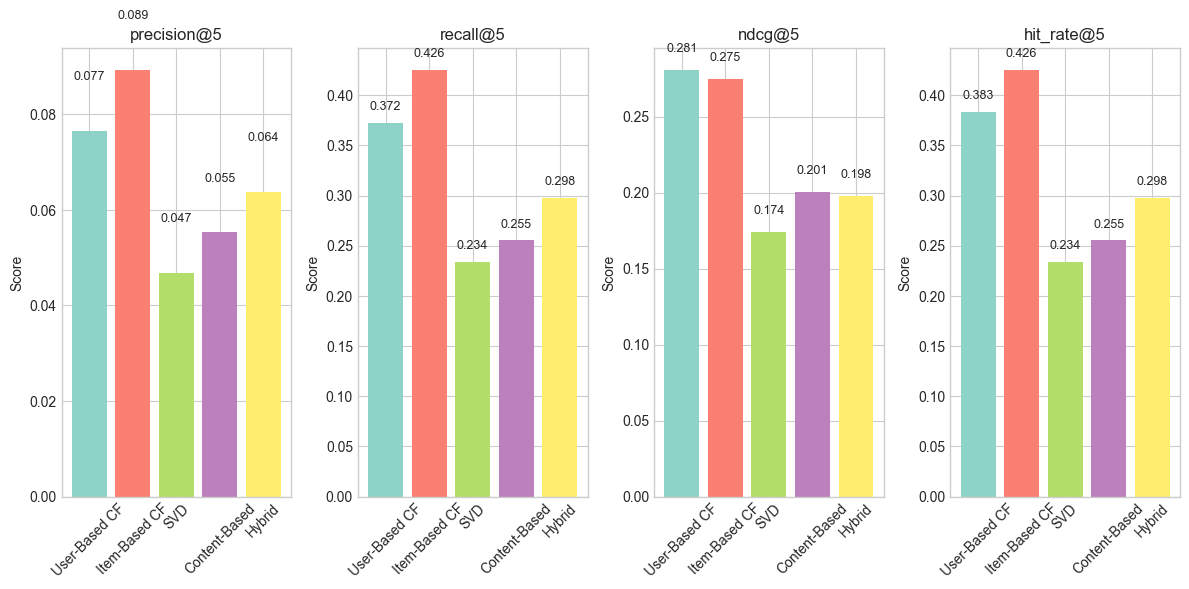

In [26]:
# Plot model comparison
metrics_to_plot = ['precision@5', 'recall@5', 'ndcg@5', 'hit_rate@5']
available_metrics = [m for m in metrics_to_plot if m in results_df.columns]

if available_metrics:
    plot_model_comparison(results, metrics=available_metrics)

## 7. Save Models for Deployment

In [27]:
# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Model directory: {MODEL_DIR}")

Model directory: /Users/durga/OpenClassrooms/Project9/P9_02_azure_function/model


In [28]:
# Save the best CF model (SVD)
cf_svd.save(os.path.join(MODEL_DIR, 'cf_svd_model.joblib'))
print("SVD model saved!")

Model saved to /Users/durga/OpenClassrooms/Project9/P9_02_azure_function/model/cf_svd_model.joblib
SVD model saved!


In [29]:
# Save content-based model
if content_model is not None:
    content_model.save(os.path.join(MODEL_DIR, 'content_based_model.joblib'))
    print("Content-based model saved!")

Model saved to /Users/durga/OpenClassrooms/Project9/P9_02_azure_function/model/content_based_model.joblib
Content-based model saved!


In [30]:
# Save hybrid model config
if hybrid_model is not None:
    hybrid_model.save(os.path.join(MODEL_DIR, 'hybrid_model.joblib'))
    print("Hybrid model config saved!")

Hybrid config saved to /Users/durga/OpenClassrooms/Project9/P9_02_azure_function/model/hybrid_model.joblib
Hybrid model config saved!


In [31]:
# Save evaluation results
results_df.to_csv(os.path.join(MODEL_DIR, 'evaluation_results.csv'))
print("\nEvaluation results saved!")

# List saved files
print("\nSaved model files:")
for f in os.listdir(MODEL_DIR):
    fpath = os.path.join(MODEL_DIR, f)
    size = os.path.getsize(fpath) / (1024*1024)
    print(f"  - {f}: {size:.2f} MB")


Evaluation results saved!

Saved model files:
  - cf_svd_model.joblib: 0.01 MB
  - content_based_model.joblib: 143.83 MB
  - hybrid_model.joblib: 0.00 MB
  - evaluation_results.csv: 0.00 MB


## 8. Test API Locally

In [32]:
# Test loading models (simulating API startup)
print("Testing model loading...")

# Load CF model
loaded_cf = CollaborativeFiltering.load(os.path.join(MODEL_DIR, 'cf_svd_model.joblib'))

# Test recommendation
test_user = list(loaded_cf.user_id_map.keys())[0]
test_recs = loaded_cf.recommend(test_user, n_recommendations=5)
print(f"\nTest recommendations for user {test_user}:")
for i, (aid, score) in enumerate(test_recs, 1):
    print(f"  {i}. Article {aid}: {score:.4f}")

print("\nModels ready for deployment!")

Testing model loading...
Model loaded from /Users/durga/OpenClassrooms/Project9/P9_02_azure_function/model/cf_svd_model.joblib

Test recommendations for user 102:
  1. Article 308807: 0.2590
  2. Article 272947: 0.1884
  3. Article 68866: 0.1551
  4. Article 106819: 0.1546
  5. Article 288431: 0.1367

Models ready for deployment!


## Summary

### Models Trained:
1. **User-Based Collaborative Filtering**: Finds similar users and recommends what they liked
2. **Item-Based Collaborative Filtering**: Finds similar items to what user has interacted with
3. **SVD Matrix Factorization**: Decomposes user-item matrix for predictions
4. **Content-Based Filtering**: Uses article embeddings for similarity
5. **Hybrid Model**: Combines CF and Content-Based approaches

### Next Steps:
1. Start the Flask API: `cd P9_02_azure_function && python app.py`
2. Start the Streamlit app: `cd P9_03_web_app && streamlit run app.py`
3. Deploy to Azure Functions for production